# Part 0: Importing packages and data

In [1]:
# Import options and modules

%matplotlib inline

import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
import random
import nltk
import re
import os 

In [2]:
# Specify data directory

data_dir = os.path.join(os.path.dirname(os.getcwd()),'Data')

In [3]:
# Import dataframe

df = pd.read_json(os.path.join(data_dir,'sms_final.json'))
df_processed = pd.read_json(os.path.join(data_dir,'sms_processed.json'))

# Adjust df. We want to convert the label back into ham/spam for meaningful representation

df.rename(columns={'token':'token_meaningful'}, inplace=True)
mapping = {0:'ham', 1:'spam'}
df.label = df.label.map(mapping)
df.head()

,label,token_meaningful
0,ham,"[go, avail, bugi, n, great, world, e, got, amo..."
1,ham,"[ok, lar, wif, u]"
10,ham,"[gon, na, home, soon, want, talk, stuff, anymo..."
100,ham,"[pleas, text, anymor, noth, els, say]"
1000,ham,[]


In [4]:
df_processed.label = df_processed.label.map(mapping)
df_processed.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
10,ham,I'm gonna be home soon and i don't want to tal...
100,ham,Please don't text me anymore. I have nothing e...
1000,ham,"Aight will do, thanks again for comin out"


In [5]:
# How skewed is the dataset
len(df[df.label == 'ham']), len(df[df.label == 'spam'])

(4825, 747)

### Extract Ham and Spam full text corpuses

In [6]:
# Importing raw text
df_raw = pd.read_csv(os.path.join(data_dir,'SMSSpamCollection.txt'), delimiter = '\t', header = None)
df_raw.columns = ['label', 'text']
df_raw.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# Extract the ham and spam text corpus

ham_text = ""
spam_text = ""
for row in df_raw[df_raw.label == 'ham'].text:
    ham_text += (' ' + row)
for row in df_raw[df_raw.label == 'spam'].text:
    spam_text += (' ' + row)

In [8]:
# Tokenization of processed text

df_processed['token'] = df_raw.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)
df_tokens = df_processed.drop('text', axis = 1)

# Part 1: Classical feature extraction

In this part, we will explore a variety of interesting classical features in the dataset. Although a lot of modern techniques for feature extraction of NLP exists (BoW, Topic modelling, Embedding), we want to explore the data and the effectiveness of modern techniques comparing to classical ones. Also, we may be able to gain insight into what the modern algorithms can and cannot do. We will explore the ham/spam dataset with the nltk package.

<p style="font-family: Arial; font-size:1.4em;color:blue;"> 1. Length of the sms </p>

In [9]:
# Create a variable for the number of tokens

df['n_token'] = [len(line) for line in df_tokens['token']]
df.head()

,label,token_meaningful,n_token
0,ham,"[go, avail, bugi, n, great, world, e, got, amo...",23
1,ham,"[ok, lar, wif, u]",8
10,ham,"[gon, na, home, soon, want, talk, stuff, anymo...",28
100,ham,"[pleas, text, anymor, noth, els, say]",14
1000,ham,[],9


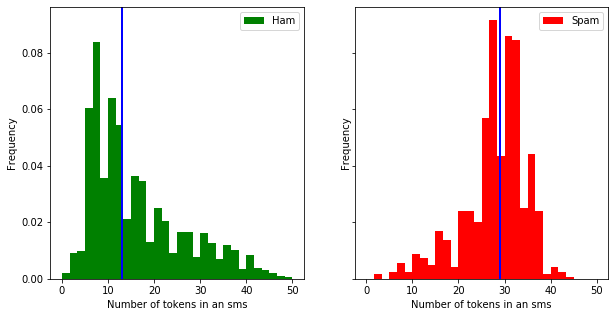

In [10]:
# Plot number of tokens within an sms

fig, axs = plt.subplots(1, 2, figsize = (10,5), sharex = True, sharey = True)
axs[0].hist(df[df.label == 'ham'].n_token, bins = 30, density = True, range = (0,50), color = 'g', label = "Ham")
axs[0].legend(loc="upper right")
axs[0].axvline(np.median(df[df.label == 'ham'].n_token), color = 'b', lw = 2, )
axs[1].hist(df[df.label == 'spam'].n_token, bins = 30, density = True, range = (0,50), color = 'r', label = "Spam")
axs[1].axvline(np.median(df[df.label == 'spam'].n_token), color = 'b', lw = 2, )
axs[1].legend(loc="upper right")


for ax in axs.flat:
    ax.set(xlabel='Number of tokens in an sms', ylabel='Frequency')
plt.show()

<div class="span5 alert alert-success">
Insight: The distribution of n_token in ham and spam are very much different. The median sms in ham is around 12 whereas the median sms length in spam is around 29. We would expect spam sms to have a higher word count.
</div>

<p style="font-family: Arial; font-size:1.4em;color:blue;"> 2. Length of the sms words </p>

In [11]:
# Find the average length of sms words in the 

# Tokenization of processed text

df_processed['token'] = df_raw.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)
df_tokens = df_processed.drop('text', axis = 1)

# Ham, spam word Corpus creation
ham_word = []
spam_word = []
for row in df_tokens[df_tokens.label == 'ham'].token :
    ham_word += row
for row in df_tokens[df_tokens.label == 'spam'].token:
    spam_word += row

In [12]:
ham_char_freq = [round(len([w for w in ham_word if len(w) == l])/len(ham_word),3) for l in range(1,20)]

In [13]:
spam_char_freq = [round(len([w for w in spam_word if len(w) == l])/len(spam_word),3) for l in range(1,20)]

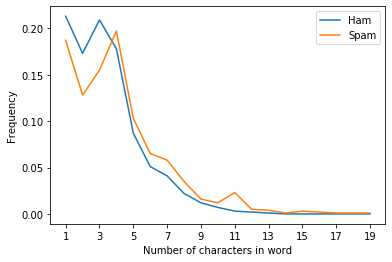

In [14]:
plt.plot(range(1,20),ham_char_freq)
plt.plot(range(1,20),spam_char_freq)
plt.xticks(range(1,20,2))
plt.legend(['Ham', 'Spam'], loc = 'upper right')
plt.xlabel('Number of characters in word')
plt.ylabel('Frequency')
plt.show()

<div class="span5 alert alert-success">
Insight: It seems that word length in ham and spam are somewhat different. However, we want to know whether the difference is significant. So we're doing hypothesis testing with a permutation test to test whether there is true difference between the datasets.
</div>


#### Using Bootstrap statistic to determine if there is significant difference in two groups.

In [15]:
# Create a list of number of characters in every word of ham and spam

ham_char = [len(w) for w in ham_word] 
spam_char = [len(w) for w in spam_word]

In [16]:
# Create a permutation, drawing and mean difference function

def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [17]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

In [18]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

Hypothesis: The number of characters in a given word in ham and spam is the same.

In [19]:
# Take the empirical difference

empirical = diff_of_means(ham_char, spam_char)
empirical

-0.7900299186079085

In [20]:
# Create permutation replicates. NOTE: the bootstrap process takes a long time, so if want to run it, I will set if 1 == 1:
if 0 == 1:
    perm_replicates = draw_perm_reps(ham_char, spam_char, diff_of_means, size=10000)
    
    # Calculate p-value
    p = np.sum(perm_replicates <= empirical) / len(perm_replicates)
    print('p-value =', p)

<div class="span5 alert alert-success">
The probability of us observing such an empirical value is very small under the Null hypothesis. Thus, we reject the Null hypothesis in favor of the alternative hypothesis, that there is a difference in word length between ham and spam.
</div>

In [21]:
# Create a list of average word length
avg_len = []
for i in range(len(df)):
    avg_len.append(np.mean([len(word) for word in df_tokens['token'][i]]))

In [22]:
df['avg_wlen'] = avg_len
df.head()

,label,token_meaningful,n_token,avg_wlen
0,ham,"[go, avail, bugi, n, great, world, e, got, amo...",23,4.000000
1,ham,"[ok, lar, wif, u]",8,3.000000
10,ham,"[gon, na, home, soon, want, talk, stuff, anymo...",28,3.459459
100,ham,"[pleas, text, anymor, noth, els, say]",14,3.000000
1000,ham,[],9,3.266667


#### We can also check to see if max/min word length is discriminative

In [23]:
# Create a list of max and min word length

max_len = []
for i in range(len(df)):
    max_len.append(max([len(word) for word in df_tokens['token'][i]]))
    
df['max_wlen'] = max_len

min_len = []
for i in range(len(df)):
    min_len.append(min([len(word) for word in df_tokens['token'][i]]))
df['min_wlen'] = min_len

In [24]:
df.head()

,label,token_meaningful,n_token,avg_wlen,max_wlen,min_wlen
0,ham,"[go, avail, bugi, n, great, world, e, got, amo...",23,4.000000,9,1
1,ham,"[ok, lar, wif, u]",8,3.000000,6,1
10,ham,"[gon, na, home, soon, want, talk, stuff, anymo...",28,3.459459,17,1
100,ham,"[pleas, text, anymor, noth, els, say]",14,3.000000,7,1
1000,ham,[],9,3.266667,6,1


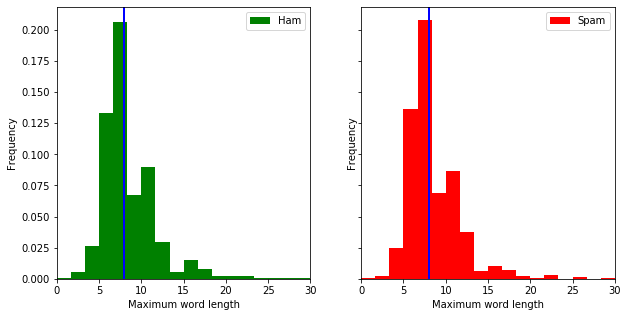

In [25]:
fig, axs = plt.subplots(1, 2, figsize = (10,5), sharex = True, sharey = True)

axs[0].hist(df[df.label == 'ham'].max_wlen, bins = 30, density = True, range = (0,50), color = 'g', label = "Ham")
axs[0].legend(loc="upper right")
axs[0].axvline(np.median(df[df.label == 'ham'].max_wlen), color = 'b', lw = 2, )

axs[1].hist(df[df.label == 'spam'].max_wlen, bins = 30, density = True, range = (0,50), color = 'r', label = "Spam")
axs[1].axvline(np.median(df[df.label == 'spam'].max_wlen), color = 'b', lw = 2, )
axs[1].legend(loc="upper right")

plt.xlim(0,30)

for ax in axs.flat:
    ax.set(xlabel='Maximum word length', ylabel='Frequency')
plt.show()

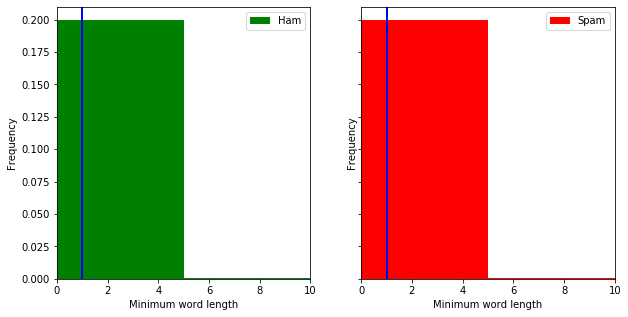

In [26]:
fig, axs = plt.subplots(1, 2, figsize = (10,5), sharex = True, sharey = True)

axs[0].hist(df[df.label == 'ham'].min_wlen, bins = 10, density = True, range = (0,50), color = 'g', label = "Ham")
axs[0].legend(loc="upper right")
axs[0].axvline(np.median(df[df.label == 'ham'].min_wlen), color = 'b', lw = 2, )

axs[1].hist(df[df.label == 'spam'].min_wlen, bins = 10, density = True, range = (0,50), color = 'r', label = "Spam")
axs[1].axvline(np.median(df[df.label == 'spam'].min_wlen), color = 'b', lw = 2, )
axs[1].legend(loc="upper right")

plt.xlim(0,10)

for ax in axs.flat:
    ax.set(xlabel='Minimum word length', ylabel='Frequency')
plt.show()

<div class="span5 alert alert-success">
This doesn't look discriminative, we will drop that feature from our model
</div>

In [27]:
df.drop(['max_wlen', 'min_wlen'], axis = 1, inplace = True)
df.head()

,label,token_meaningful,n_token,avg_wlen
0,ham,"[go, avail, bugi, n, great, world, e, got, amo...",23,4.000000
1,ham,"[ok, lar, wif, u]",8,3.000000
10,ham,"[gon, na, home, soon, want, talk, stuff, anymo...",28,3.459459
100,ham,"[pleas, text, anymor, noth, els, say]",14,3.000000
1000,ham,[],9,3.266667


<p style="font-family: Arial; font-size:1.4em;color:blue;"> 3. Number of Numerics </p>

In [28]:
df_tokens_alnum = df_tokens

In [29]:
# Return numerics tokens and number of numerics in a row

df_tokens_alnum['numerics'] = df_tokens_alnum.apply(lambda row: [word for word in row['token'] if word.isdigit()], axis = 1)
df['n_num'] = df_tokens_alnum.apply(lambda row: len(row['numerics']), axis = 1)
df.head()

,label,token_meaningful,n_token,avg_wlen,n_num
0,ham,"[go, avail, bugi, n, great, world, e, got, amo...",23,4.000000,0
1,ham,"[ok, lar, wif, u]",8,3.000000,0
10,ham,"[gon, na, home, soon, want, talk, stuff, anymo...",28,3.459459,0
100,ham,"[pleas, text, anymor, noth, els, say]",14,3.000000,0
1000,ham,[],9,3.266667,0


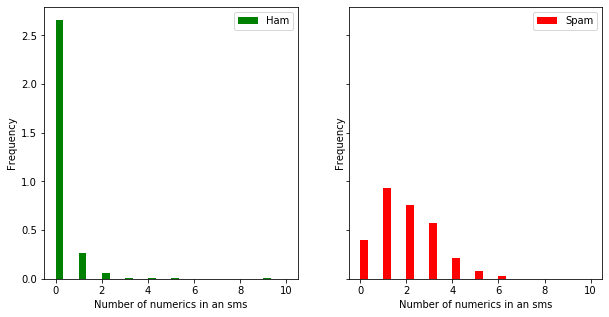

In [30]:
# Plot number of numerics within an sms

fig, axs = plt.subplots(1, 2, figsize = (10,5), sharex = True, sharey = True)
axs[0].hist(df[df.label == 'ham'].n_num, bins = 30, density = True, range = (0,10), color = 'g', label = "Ham")
axs[0].legend(loc="upper right")
axs[1].hist(df[df.label == 'spam'].n_num, bins = 30, density = True, range = (0,10), color = 'r', label = "Spam")
axs[1].legend(loc="upper right")

for ax in axs.flat:
    ax.set(xlabel='Number of numerics in an sms', ylabel='Frequency')
    
plt.show()

<div class="span5 alert alert-success">
Insight: Clearly ham sms don't use as many numerics and spam text. In fact, you would expect most ham text not to contain numbers whereas spam text will most likely contain numbers. We can extract a binary feature has_number for our model.
</div>

In [31]:
# Extract has_num feature

df['has_num'] = np.where(df['n_num'] == 0, 0, 1)
df.head()

,label,token_meaningful,n_token,avg_wlen,n_num,has_num
0,ham,"[go, avail, bugi, n, great, world, e, got, amo...",23,4.000000,0,0
1,ham,"[ok, lar, wif, u]",8,3.000000,0,0
10,ham,"[gon, na, home, soon, want, talk, stuff, anymo...",28,3.459459,0,0
100,ham,"[pleas, text, anymor, noth, els, say]",14,3.000000,0,0
1000,ham,[],9,3.266667,0,0


<p style="font-family: Arial; font-size:1.4em;color:blue;"> 4. Number of Uppercase </p>

In [32]:
df_tokens_upper = df_tokens

In [33]:
# Return Uppercased tokens and the number of Uppercased in a row

df_tokens_upper['uppers'] = df_tokens_upper.apply(lambda row: [word for word in row['token'] if word.isupper()], axis = 1)
df['n_upper'] = df_tokens_upper.apply(lambda row: len(row['uppers']), axis = 1)
df.head()

,label,token_meaningful,n_token,avg_wlen,n_num,has_num,n_upper
0,ham,"[go, avail, bugi, n, great, world, e, got, amo...",23,4.000000,0,0,0
1,ham,"[ok, lar, wif, u]",8,3.000000,0,0,0
10,ham,"[gon, na, home, soon, want, talk, stuff, anymo...",28,3.459459,0,0,2
100,ham,"[pleas, text, anymor, noth, els, say]",14,3.000000,0,0,1
1000,ham,[],9,3.266667,0,0,0


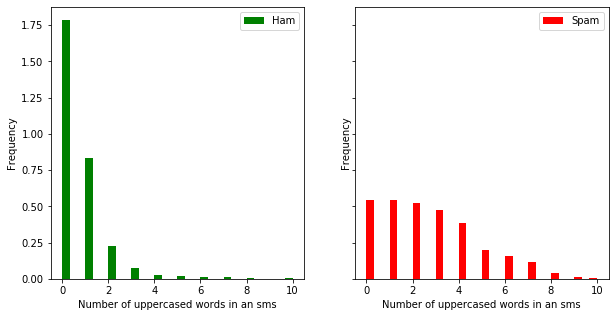

In [34]:
# Plot number of uppercased words within an sms

fig, axs = plt.subplots(1, 2, figsize = (10,5), sharex = True, sharey = True)
axs[0].hist(df[df.label == 'ham'].n_upper, bins = 30, density = True, range = (0,10), color = 'g', label = "Ham")
axs[0].legend(loc="upper right")
axs[1].hist(df[df.label == 'spam'].n_upper, bins = 30, density = True, range = (0,10), color = 'r', label = "Spam")
axs[1].legend(loc="upper right")

for ax in axs.flat:
    ax.set(xlabel='Number of uppercased words in an sms', ylabel='Frequency')
    
plt.show()

<div class="span5 alert alert-success">
Insight: Again, ham text has much less uppercases than spam text. However, this time it's less obvious since a significant number of ham text still has Upercases. We would expect very few ham text to have > 2 upercases letters though.
</div>

<p style="font-family: Arial; font-size:1.4em;color:blue;"> 5. Number of Stopwords </p>

In [35]:
df_tokens_stop = df_tokens

In [36]:
# Return stopwords tokens and the number of stopwords in a row

from nltk.corpus import stopwords
df_tokens_stop['stops'] = df_tokens_stop.apply(lambda row: [word for word in row['token'] if word in stopwords.words('english')], axis = 1)
df['n_stops'] = df_tokens_stop.apply(lambda row: len(row['stops']), axis = 1)
df.head()

,label,token_meaningful,n_token,avg_wlen,n_num,has_num,n_upper,n_stops
0,ham,"[go, avail, bugi, n, great, world, e, got, amo...",23,4.000000,0,0,0,4
1,ham,"[ok, lar, wif, u]",8,3.000000,0,0,0,0
10,ham,"[gon, na, home, soon, want, talk, stuff, anymo...",28,3.459459,0,0,2,7
100,ham,"[pleas, text, anymor, noth, els, say]",14,3.000000,0,0,1,4
1000,ham,[],9,3.266667,0,0,0,5


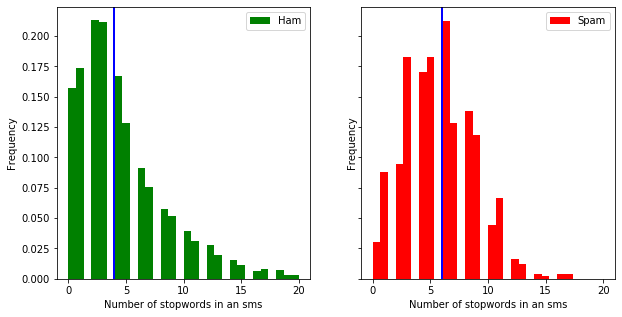

In [37]:
# Plot number of stopwords words within an sms

fig, axs = plt.subplots(1, 2, figsize = (10,5), sharex = True, sharey = True)
axs[0].hist(df[df.label == 'ham'].n_stops, bins = 30, density = True, range = (0,20), color = 'g', label = "Ham")
axs[0].legend(loc="upper right")
axs[0].axvline(np.median(df[df.label == 'ham'].n_stops), color = 'b', lw = 2, )
axs[1].hist(df[df.label == 'spam'].n_stops, bins = 30, density = True, range = (0,20), color = 'r', label = "Spam")
axs[1].legend(loc="upper right")
axs[1].axvline(np.median(df[df.label == 'spam'].n_stops), color = 'b', lw = 2, )

for ax in axs.flat:
    ax.set(xlabel='Number of stopwords in an sms', ylabel='Frequency')
    
plt.show()

<div class="span5 alert alert-success">
Insight: The distribution of stopwords used in the ham and spam dataset is different, but the median is quite close (approximately 4 for ham vs 6 for spam). The ham stopwords looks like an exponential or gamma distribution. Whereas the spam dataset looks close to a normal distribution with a long tail.
</div>

<p style="font-family: Arial; font-size:1.4em;color:blue;"> 6. Email addresses, Money Symbols, Phone Numbers and Urls </p>

In [38]:
# Create new columns for our variables for messages

df_processed['has_email'] = [1 if '{EmAd}' in line else 0 for line in df_processed.text]
df_processed['has_money'] = [1 if '{MoSy}' in line else 0 for line in df_processed.text]
df_processed['has_phone'] = [1 if '{PhNu}' in line else 0 for line in df_processed.text]
df_processed['has_url'] = [1 if 'Url' in line else 0 for line in df_processed.text]

In [39]:
# Determine the spamminess of an email

df_processed.groupby('label').sum()

,has_email,has_money,has_phone,has_url
label,,,,
ham,3,19,1,0
spam,18,256,405,21


<div class="span5 alert alert-success">
Insight: It looks as though all four of these features are quite spammy. However, the number of observation is limited for some, such as has_email and has_url. Nevertheless, we can still use it as our features.
</div>

In [40]:
df['has_email'] = df_processed['has_email']
df['has_money'] = df_processed['has_money']
df['has_phone'] = df_processed['has_phone']
df['has_url'] = df_processed['has_url']

In [41]:
df.head()

,label,token_meaningful,n_token,avg_wlen,n_num,has_num,n_upper,n_stops,has_email,has_money,has_phone,has_url
0,ham,"[go, avail, bugi, n, great, world, e, got, amo...",23,4.000000,0,0,0,4,0,0,0,0
1,ham,"[ok, lar, wif, u]",8,3.000000,0,0,0,0,0,0,0,0
10,ham,"[gon, na, home, soon, want, talk, stuff, anymo...",28,3.459459,0,0,2,7,0,0,0,0
100,ham,"[pleas, text, anymor, noth, els, say]",14,3.000000,0,0,1,4,0,0,0,0
1000,ham,[],9,3.266667,0,0,0,5,0,0,0,0


<p style="font-family: Arial; font-size:1.4em;color:blue;"> 7. Relative Frequency of Tokens </p>

In [42]:
# Let's take a look at some of the relatively more common tokens in both sets. We first have to documentize the rows according to their label

ham_token = []
spam_token = []
for row in df[df.label == 'ham'].token_meaningful :
    ham_token += row
for row in df[df.label == 'spam'].token_meaningful:
    spam_token += row

In [43]:
# Create a frequency distribution of the tokens

ham_fdist = nltk.FreqDist(ham_token)
spam_fdist = nltk.FreqDist(spam_token)
ham_fdist.most_common(10), spam_fdist.most_common(10)

([('u', 991),
  ('go', 417),
  ('get', 359),
  ('gt', 318),
  ('lt', 316),
  ('come', 295),
  ('call', 290),
  ('ok', 247),
  ('know', 247),
  ('ur', 247)],
 [('phnu', 440),
  ('call', 372),
  ('mosi', 327),
  ('free', 217),
  ('txt', 169),
  ('u', 145),
  ('ur', 144),
  ('text', 139),
  ('mobil', 135),
  ('stop', 118)])

In [44]:
# Create a frequency distribution for the words in both lists

all_fdist = nltk.FreqDist(ham_token + spam_token)
all_fdist

FreqDist({'u': 1136, 'call': 662, 'go': 452, 'get': 447, 'phnu': 441, 'ur': 391, 'mosi': 351, 'gt': 318, 'lt': 316, 'come': 300, ...})

In [45]:
# Create the key and value for our ham_ratio_dict, which will contain the ratio of # times a word appear in ham comparing to all documents
# These words must appear more than 100 times in the ham_word

ham_wname = [w for w in ham_fdist if ham_fdist[w] > 100]
ham_fdist_ratio = [ham_fdist[w]/all_fdist[w] for w in ham_fdist if ham_fdist[w] > 100]
ham_fdist_ratio = [r for r in ham_fdist_ratio if r > 0.5]

In [46]:
ham_ratio_dict = dict(zip(ham_wname, ham_fdist_ratio))

In [47]:
# sort the dictionary according to the ratio value
for elem in sorted(ham_ratio_dict.items(), key=lambda x: x[1] , reverse = True) :
        print(elem[0] , "-" , elem[1] )

lt - 1.0
gt - 1.0
ü - 1.0
call - 1.0
pl - 1.0
work - 1.0
say - 0.9928057553956835
happi - 0.9915254237288136
way - 0.991304347826087
night - 0.9912280701754386
wat - 0.9907407407407407
da - 0.9901960784313726
home - 0.9875
love - 0.9833333333333333
r - 0.9810126582278481
ok - 0.9801587301587301
time - 0.9774436090225563
come - 0.9734513274336283
got - 0.9722222222222222
hope - 0.9692307692307692
miss - 0.9585062240663901
sorri - 0.9557522123893806
still - 0.9548387096774194
ask - 0.9545454545454546
take - 0.952
good - 0.9504132231404959
lor - 0.9498069498069498
oh - 0.9456521739130435
well - 0.9426229508196722
dont - 0.9408602150537635
n - 0.9403973509933775
meet - 0.9236111111111112
go - 0.922566371681416
thing - 0.9224489795918367
give - 0.9224137931034483
back - 0.9186991869918699
think - 0.9156626506024096
later - 0.9145299145299145
like - 0.9115646258503401
know - 0.9047619047619048
great - 0.9026548672566371
see - 0.8888888888888888
make - 0.8848484848484849
tell - 0.884615384615

In [48]:
# Similar steps for ham

spam_wname = [w for w in spam_fdist if spam_fdist[w] > 100]
spam_fdist_ratio = [spam_fdist[w]/all_fdist[w] for w in spam_fdist if spam_fdist[w] > 100]
spam_fdist_ratio = [r for r in spam_fdist_ratio if r > 0.5]

In [49]:
spam_ratio_dict = dict(zip(spam_wname, spam_fdist_ratio))

In [50]:
for elem in sorted(spam_ratio_dict.items(), key=lambda x: x[1] , reverse = True) :
        print(elem[0] , "-" , elem[1] )

stop - 1.0
phnu - 0.9977324263038548
mosi - 0.9316239316239316
ur - 0.9285714285714286
repli - 0.9
free - 0.7890909090909091
txt - 0.7283950617283951
u - 0.7133757961783439
claim - 0.6177777777777778
call - 0.5619335347432024


In [51]:
# Let's make a word cloud for frequent words

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [52]:
ham_mword = []
spam_mword = []
for row in df[df.label == 'ham'].token_meaningful :
    ham_mword += row
for row in df[df.label == 'spam'].token_meaningful:
    spam_mword += row

In [53]:
wordcloud_ham = WordCloud(max_font_size=1000, max_words=100, width=1500, height=1000, background_color="white").generate(str(ham_mword))
wordcloud_spam = WordCloud(max_font_size=1000, max_words=100, width=1500, height=1000, background_color="white").generate(str(spam_mword))

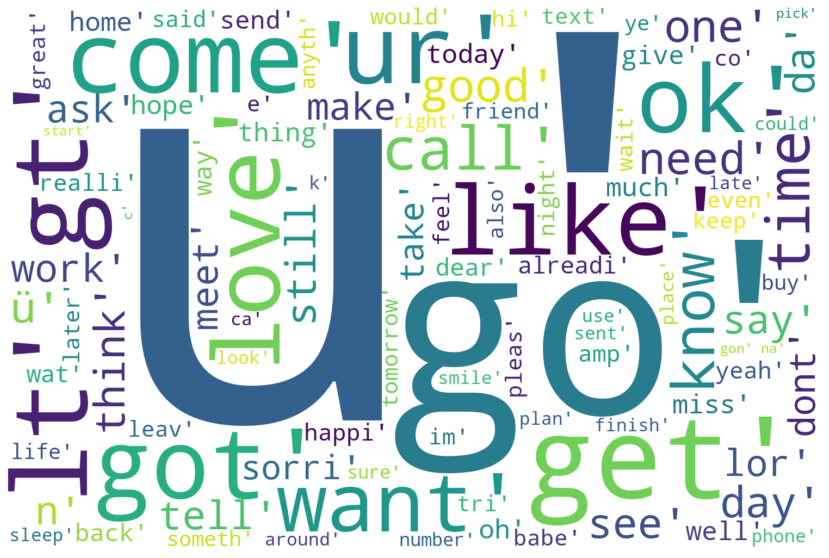

In [54]:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.axis('off')
plt.show()

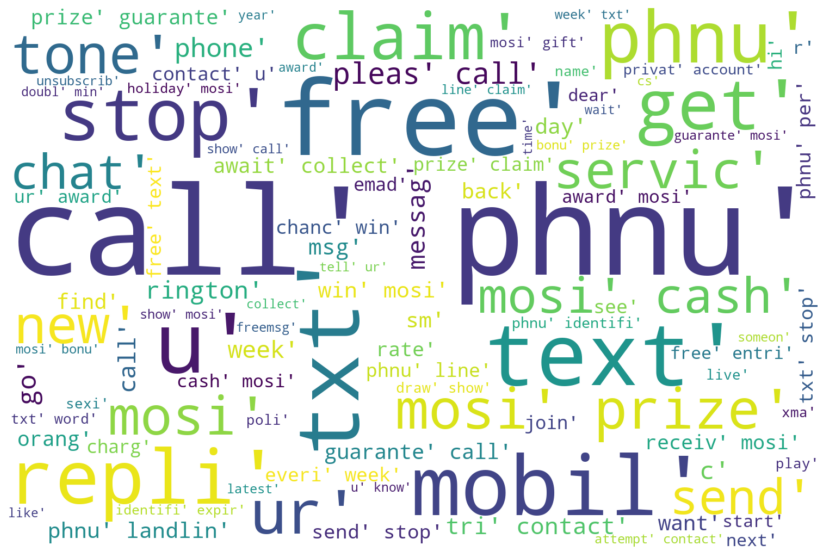

In [55]:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis('off')
plt.show()

# Part 2: Modern EDA techniques

We explore a few modern techniques of visualization here, with the visualization of the Part of Speech using spacy and topic modelling with gensim

<p style="font-family: Arial; font-size:1.4em;color:blue;"> 1. Part of speech analysis with Spacy</p>

In [56]:
# Import spacy

import spacy

nlp = spacy.load('en_core_web_sm')

In [57]:
# parse data from the ham and spam text corpus

ham_spacy, spam_spacy = nlp(ham_text), nlp(spam_text)

In [58]:
# Create a part of speech dataframe for the ham tokens

token_text = [token.orth_ for token in ham_spacy]
token_pos = [token.pos_ for token in ham_spacy]

ham_spacy_pos = pd.DataFrame(zip(token_text, token_pos),
                             columns=['ham_token_text', 'part_of_speech'])

In [59]:
# Create a part of speech dataframe for the spam tokens

token_text = [token.orth_ for token in spam_spacy]
token_pos = [token.pos_ for token in spam_spacy]

spam_spacy_pos = pd.DataFrame(zip(token_text, token_pos),
                             columns=['spam_token_text', 'part_of_speech'])

In [60]:
# Analyze the important PoS: Noun, Pronoun, Proper Noun, Adjective, Verb and Symbol

labels = ['Noun', 'Pronoun', 'Proper Noun', 'Adjective', 'Verb', 'Symbol']

ham_pos_value = [sum(ham_spacy_pos['part_of_speech'] == 'NOUN'),
                 sum(ham_spacy_pos['part_of_speech'] == 'PRON'),
                 sum(ham_spacy_pos['part_of_speech'] == 'PROPN'),
                 sum(ham_spacy_pos['part_of_speech'] == 'ADJ'),
                 sum(ham_spacy_pos['part_of_speech'] == 'VERB'),
                 sum(ham_spacy_pos['part_of_speech'] == 'SYM')]

spam_pos_value = [sum(spam_spacy_pos['part_of_speech'] == 'NOUN'),
                 sum(spam_spacy_pos['part_of_speech'] == 'PRON'),
                 sum(spam_spacy_pos['part_of_speech'] == 'PROPN'),
                 sum(spam_spacy_pos['part_of_speech'] == 'ADJ'),
                 sum(spam_spacy_pos['part_of_speech'] == 'VERB'),
                 sum(spam_spacy_pos['part_of_speech'] == 'SYM')]

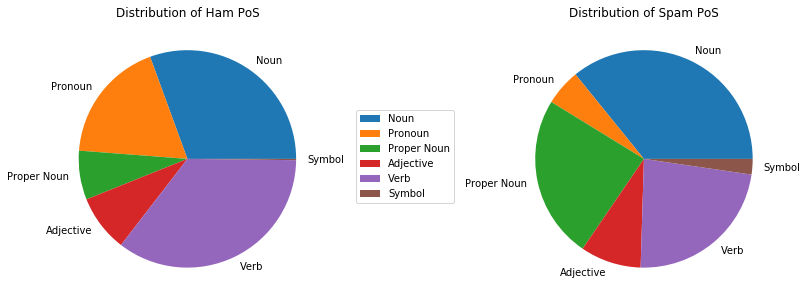

In [61]:
# Plot number of stopwords words within an sms

fig, axs = plt.subplots(1, 2, figsize = (15,5))
axs[0].pie(x = ham_pos_value, labels = labels)
axs[0].legend(loc="upper right", bbox_to_anchor=(1.5, 0.7))
axs[0].set_title('Distribution of Ham PoS')
axs[1].pie(x = spam_pos_value, labels = labels)
axs[1].set_title('Distribution of Spam PoS')

plt.show()

<div class="span5 alert alert-success">
Insight: A few interesting things pop up. First off, Symbols appear very infrequently among ham tokens in comparison to spam tokens. This confirms our suspicion that generators of symbols like emails and money will indicate spamminess. Additionally, there is relatively more pronouns and verbs in ham tokens and more Proper noun is spams. I suspect that the pronouns are more personal and thus more likely in a ham, the Proper noun is more spammy because there are more brand names.An idea comes to mind to integrate such information in our model with proportion of verb, proportion of pronouns and proportion of Propernouns.Such idea might be revealing to pursue, however, it seems arbitrary and may introduce more noise into our model.
</div>

<p style="font-family: Arial; font-size:1.4em;color:blue;"> 2. Topic modelling with gensim </p>

#### Preprocessing

In [62]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [63]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [64]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df_raw.text))

print(data_words[:1])

[['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'great', 'world', 'la', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']]


In [65]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[9]]])

['had', 'your', 'mobile', 'months', 'or', 'more', 'entitled', 'to', 'update', 'to', 'the', 'latest_colour', 'mobiles', 'with', 'camera', 'for', 'free', 'call', 'the', 'mobile', 'update', 'co', 'free', 'on']


In [66]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [67]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'great', 'world', 'buffet', 'cine', 'get', 'amore', 'wat']]


#### Create dictionary and Corpus for topic modelling

In [68]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)]]


#### LDA model and visualization

In [69]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [70]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.165*"not" + 0.110*"do" + 0.044*"miss" + 0.041*"pick" + 0.032*"even" + 0.027*"lol" + 0.026*"bad" + 0.024*"hear" + 0.013*"frm" + 0.012*"chat"'), (1, '0.078*"mobile" + 0.061*"txt" + 0.041*"new" + 0.035*"reply" + 0.028*"free" + 0.027*"win" + 0.026*"text" + 0.024*"tone" + 0.021*"year" + 0.019*"easy"'), (2, '0.062*"smile" + 0.050*"cash" + 0.025*"someone" + 0.024*"pm" + 0.019*"hurt" + 0.017*"guarantee" + 0.016*"med" + 0.015*"limit" + 0.014*"texte" + 0.013*"self"'), (3, '0.033*"min" + 0.029*"thing" + 0.028*"dear" + 0.022*"last" + 0.022*"wish" + 0.020*"cos" + 0.017*"also" + 0.016*"would" + 0.013*"long" + 0.013*"heart"'), (4, '0.102*"see" + 0.068*"text" + 0.049*"wait" + 0.037*"www" + 0.030*"urgent" + 0.022*"enough" + 0.018*"word" + 0.018*"co_uk" + 0.017*"decide" + 0.015*"run"'), (5, '0.130*"come" + 0.066*"take" + 0.064*"work" + 0.043*"s" + 0.040*"buy" + 0.035*"life" + 0.029*"plan" + 0.025*"have" + 0.022*"finish" + 0.021*"check"'), (6, '0.255*"get" + 0.094*"time" + 0.047*"try" + 0.030*"al

In [71]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.69553604443963

Coherence Score:  0.5202745130825177


<div class="span5 alert alert-success">
The perplexity of the model is quite low, which shows that there is a low likelihood of unseen documents. This is not strongly correlated with a good model, however, so we also need coherence score. A score of 0.52 is ok, but it is still a long way from a good topic modelling model. We will try to visualize the topics into to gain deeper understanding.
</div>

In [72]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

Z:\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
3      0.059210  0.410789       1        1  9.808097
17    -0.321289  0.025520       2        1  6.288782
6      0.050507 -0.016905       3        1  6.150605
7      0.053101 -0.016283       4        1  6.106105
13     0.044973 -0.011899       5        1  5.819120
1     -0.147306 -0.036229       6        1  5.358781
5      0.048338 -0.015532       7        1  5.050306
14     0.048429 -0.024000       8        1  5.037871
8      0.050323 -0.024926       9        1  4.781780
15     0.035477 -0.025418      10        1  4.747899
4     -0.000512 -0.050366      11        1  4.715015
12     0.043237 -0.031311      12        1  4.550746
11     0.037133 -0.022033      13        1  4.449136
18     0.035321 -0.034222      14        1  4.398686
19    -0.230232  0.025315      15        1  4.331558
0      0.034177 -0.023552      16        1  4.291978
9      0.048231 -0.034976      17        1  4.253830
10     0.039770 -0.028775      18        1  4.135756
2      0.034062 -0.032562      19        1  2.934549
16     0.037048 -0.032633      20        1  2.789401, topic_info=     Category        Freq        Term       Total  loglift  logprob
6     Default  651.000000         get  651.000000  30.0000  30.0000
7     Default  584.000000          go  584.000000  29.0000  29.0000
72    Default  629.000000        call  629.000000  28.0000  28.0000
125   Default  293.000000         not  293.000000  27.0000  27.0000
371   Default  272.000000        come  272.000000  26.0000  26.0000
106   Default  256.000000         day  256.000000  25.0000  25.0000
191   Default  233.000000        know  233.000000  24.0000  24.0000
318   Default  242.000000        good  242.000000  23.0000  23.0000
131   Default  240.000000        time  240.000000  22.0000  22.0000
234   Default  208.000000        tell  208.000000  21.0000  21.0000
101   Default  211.000000        want  211.000000  20.0000  20.0000
48    Default  203.000000        send  203.000000  19.0000  19.0000
156   Default  196.000000          do  196.000000  18.0000  18.0000
254   Default  200.000000         see  200.000000  17.0000  17.0000
21    Default  266.000000        free  266.000000  16.0000  16.0000
210   Default  181.000000        love  181.000000  15.0000  15.0000
40    Default  184.000000       think  184.000000  14.0000  14.0000
89    Default  173.000000      mobile  173.000000  13.0000  13.0000
428   Default  158.000000        stop  158.000000  12.0000  12.0000
37    Default  169.000000         say  169.000000  11.0000  11.0000
28    Default  191.000000        text  191.000000  10.0000  10.0000
99    Default  148.000000       today  148.000000   9.0000   9.0000
146   Default  143.000000        make  143.000000   8.0000   8.0000
268   Default  144.000000        need  144.000000   7.0000   7.0000
317   Default  143.000000        give  143.000000   6.0000   6.0000
95    Default  136.000000        home  136.000000   5.0000   5.0000
180   Default  134.000000         lor  134.000000   4.0000   4.0000
51    Default  137.000000        week  137.000000   3.0000   3.0000
129   Default  138.000000        take  138.000000   2.0000   2.0000
209   Default  146.000000       leave  146.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
63    Topic20   80.556145      friend   81.384911   3.5691  -2.6641
413   Topic20   53.814377   something   54.643143   3.5641  -3.0675
774   Topic20   51.642200         guy   52.470966   3.5634  -3.1087
1141  Topic20   48.987991     problem   49.816757   3.5626  -3.1615
199   Topic20   22.900160         tho   23.728926   3.5438  -3.9219
1723  Topic20   22.266668         gud   23.095434   3.5428  -3.9500
1768  Topic20   19.224997      family   20.053762   3.5371  -4.0969
2524  Topic20   18.697113     support   19.525879   3.5360  -4.1247
70    Topic20   14.313714         set   15.142481   3.5231  -4.3918
176

<div class="span5 alert alert-success">
Insight: Exploring the data, we can see immediately the divide between the hammy topics and spammy topics. Particularly, topics on the left side of PC1 are likely to be spammy (topic 2, 6, 15) wheras topics on the right side of PC1 are hammy (the rest). Some examples of spammy words from topic 2, 6 and 15 are claim, prize, text, call, free, msg ... This shows that the topic models also confirms a strong . It seems using a bag of word model will give us strong results since word frequency are strongly predictive of class and given how both word-to-topic and topic to classification relationships seems to be very well in our analysis. </div>

<p style="font-family: Arial; font-size:1.4em;color:purple;"> EDA Conclusion: There seems to be strong differences in the structure of the Ham and Spam datasets in terms of sms length, sms word length, number of numerics, stopwords, uppercased letter used and various symbols. We can try to build a model incorporating these extracted variables as a baseline and word vectorizing model to measure our performances. Different ways of combining or stacking the two models can also be explored</p>

In [73]:
df.drop('token_meaningful', axis = 1).to_json(os.path.join(data_dir, 'sms_to_ml.json'))